In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from PIL import Image
import cv2
import os
from skimage import color, util, transform as trans, filters, feature, segmentation, morphology
from scipy import ndimage, signal
from sklearn import cluster

In [137]:
images_path = os.path.join('dataset', 'images')
DS = pd.read_csv(os.path.join('dataset', 'dataset.csv'))

def get(filename):
    return np.array(Image.open(os.path.join(images_path, filename)))

def by_id(i):
    return get(f'{i}.jpg')

def random_images(k=1, names=False):
    fnames = np.random.choice(os.listdir(images_path), k)
    images = tuple(map(get, fnames))
    if names: return images, fnames
    else: return images

def seg1(img):
    img = filters.farid(img)
    kn = (14, 14)
    im_mean = ndimage.uniform_filter(img, kn)
    im_sqr_mean = ndimage.uniform_filter(img**2, kn)
    im_var = ndimage.minimum_filter(im_sqr_mean - im_mean**2, (4, 4))
    data = im_var.flatten()
    km = cluster.KMeans(3)
    cluster_id = km.fit_predict(data.reshape(-1, 1))
    min_bin = None
    f = 0
    for ii in np.unique(cluster_id):
        subset = data[cluster_id == ii]
        hist, bins = np.histogram(subset, bins=50)
        if min_bin == None or bins.max() < min_bin:
            min_bin = bins.max()
            f = bins[:-1][hist == hist.min()][-1]
    imth = im_var < min_bin
    mask = ndimage.binary_dilation(ndimage.binary_closing(ndimage.binary_opening(imth, iterations=10), iterations=10), iterations=5)
    #ndimage.binary_dilation(ndimage.binary_fill_holes(morphology.area_opening(imth, area_threshold=200)))
    return mask

def seg2(img):
    img = filters.farid(rescale(trans.resize(img, (75, 75)), 0, 10).astype(int))
    im_var = trans.resize(var(filters.farid(img), (10, 10), (5, 5)), (256, 256))
    data = im_var.flatten()
    km = cluster.KMeans(3)
    cluster_id = km.fit_predict(data.reshape(-1, 1))
    min_bin = None
    for ii in np.unique(cluster_id):
        subset = data[cluster_id == ii]
        hist, bins, _ = plt.hist(subset, bins=50, label=ii)
        if min_bin == None or bins.max() < min_bin:
            min_bin = np.max(subset)
    imth = im_var < min_bin
    mask = ndimage.binary_opening(imth, iterations=10)
    return mask

def fft2d(image):
    return np.fft.fftshift(np.fft.fft2(np.fft.ifftshift(image)))

def peaks_filter(x, y, peaks, k=1):
    ypeaks = y[peaks]
    xpeaks = x[peaks]
    max_peak = peaks[ypeaks == ypeaks.max()]
    for _ in range(k-1):
        max_peak = peaks[ypeaks == ypeaks[np.isin(ypeaks, y[x < x[max_peak][0]])].max()]
    return max_peak

def freq_peaks(image):
    fft = np.abs(fft2d(image))
    xfreqs = np.fft.ifftshift(np.fft.fftfreq(fft.shape[0], 1))
    yfreqs = np.fft.ifftshift(np.fft.fftfreq(fft.shape[1], 1))
    
    ymean = np.mean(fft, axis=1)
    xmean = np.mean(fft, axis=0)
    
    (ypeaks, _), (xpeaks, _) = signal.find_peaks(ymean), signal.find_peaks(xmean)
    Py = peaks_filter(yfreqs, ymean, ypeaks, 2)
    Px = peaks_filter(xfreqs, xmean, xpeaks, 2)
    
    return np.abs(xfreqs[Px][0]), np.abs(xfreqs[Py][0])

In [3]:
def rescale(img, fmin, fmax):
    return fmin + (img - img.min())*(fmax - fmin)/(img.max() - img.min())

def entropy(img, r=3):
    return filters.rank.entropy(util.img_as_ubyte(rescale(img, -1, 1)), morphology.disk(3))

def var(img, kn=(15, 15), kp=(5, 5)):
    return ndimage.minimum_filter(ndimage.uniform_filter(img, kn) - ndimage.uniform_filter(img**2, kn)**2, kp)

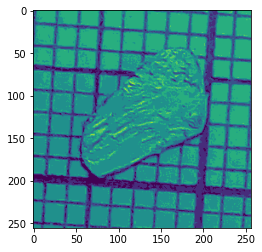

In [113]:
image = by_id(150)
img = rescale(color.rgb2gray(image), 0, 8).astype(int)
plt.imshow(img)

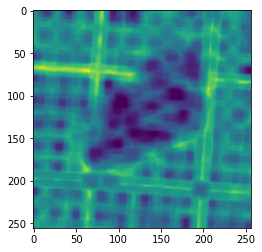

In [124]:
im_var = var(filters.farid(ndimage.gaussian_filter(img, 2)))
plt.imshow(im_var)

## Clusterização

In [125]:
data = im_var.flatten()
km = cluster.KMeans(3)
cluster_id = km.fit_predict(data.reshape(-1, 1))

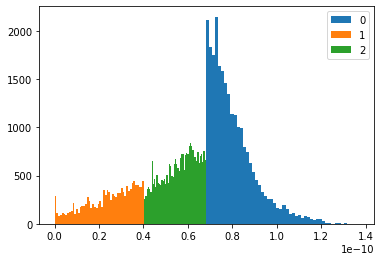

In [126]:
min_bin = None
for ii in np.unique(cluster_id):
    subset = data[cluster_id == ii]
    hist, bins, _ = plt.hist(subset, bins=50, label=ii)
    if min_bin == None or bins.max() < min_bin:
        min_bin = np.max(subset)
plt.legend()
plt.show()

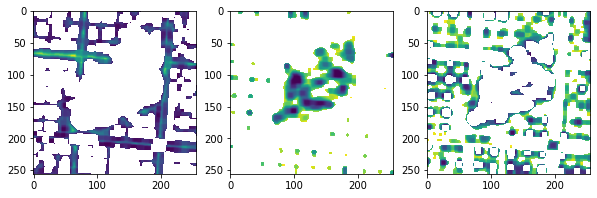

In [127]:
fig, axs = plt.subplots(1, 3, figsize=(10, 3))
kernels = km.predict(im_var.flatten().reshape(-1, 1)).reshape((256, 256))
for i, ax in enumerate(axs):
    ax.imshow(np.where(kernels == i, im_var, np.nan))
plt.show()

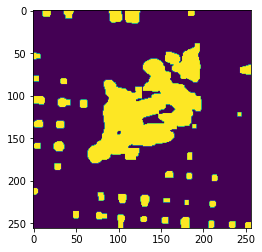

In [128]:
imth = im_var < min_bin
plt.imshow(imth)

## Ajuste morfológico

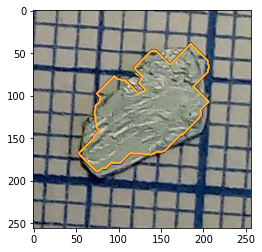

In [134]:
'''mask = ndimage.binary_dilation(
    ndimage.binary_fill_holes(
        morphology.area_opening(imth)
    )
)'''
mask = ndimage.binary_dilation(ndimage.binary_closing(ndimage.binary_opening(imth, iterations=10), iterations=10), iterations=10)
plt.imshow(image)
plt.contour(mask, cmap='inferno')

215.jpg, 146.jpg, 118.jpg, 75.jpg, 2.jpg, 97.jpg, 1.jpg, 3.jpg, 148.jpg, 92.jpg, 

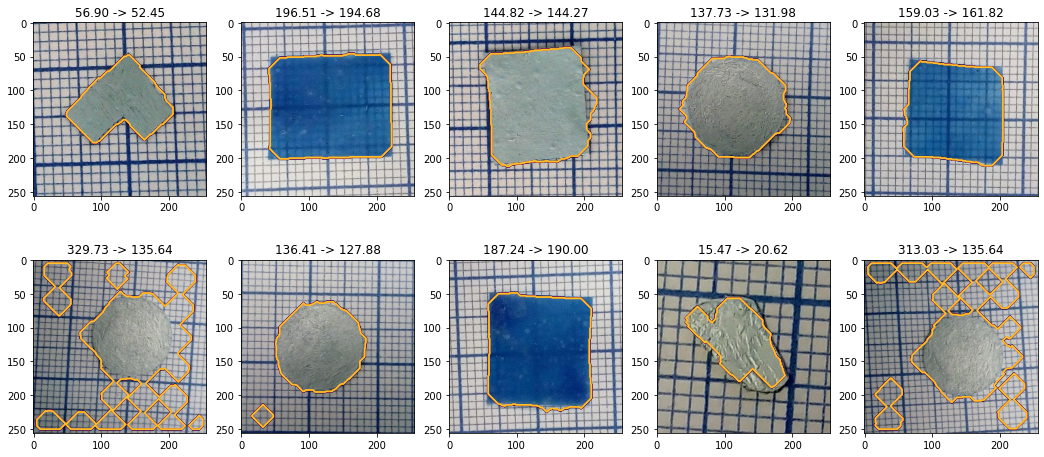

In [139]:
n = 5
fig, axs = plt.subplots(2, n, figsize=(18, 8))
axs = axs.flatten()

for i, (img, name) in enumerate(zip(*random_images(n*2, names=True))):
    print(name, end=', ')
    axs[i].imshow(img)
    gray_img = color.rgb2gray(img)
    S = seg1(rescale(gray_img, 0, 8).astype(int))
    axs[i].contour(S, cmap='inferno')
    fx, fy = freq_peaks(gray_img)
    axs[i].set_title(f'{np.sum(S)*fx*fy:.2f} -> {float(DS.loc[DS.filename == name].area):.2f}')
    
plt.show()